In [1]:
import sys
import os.path
import statistics
from matplotlib import pyplot as plt
import pandas
from SciServer import CasJobs
import numpy as np


In [61]:
class EpochData:
    
    def calculateAverageChannel(self):
        avg_channel = []
        for time_index in range(len(self.zeroed_eeg_channels[0])):
            avg_reading = 0
            for channel_index in range(len(self.zeroed_eeg_channels)):
                avg_reading = avg_reading + self.zeroed_eeg_channels[channel_index][time_index]
            avg_reading = avg_reading / len(self.zeroed_eeg_channels)
            avg_channel.append(avg_reading)
        
        self.avg_channel = avg_channel
    #take absolute value of voltages, subtract median from each
    def zeroVoltages(self):
        self.zeroed_eeg_channels = []
        for channel_index in range(len(self.eeg_voltages[0])):
            cur_channel = [reading[channel_index] for reading in self.eeg_voltages]
            channel_median = statistics.median(cur_channel)
            self.zeroed_eeg_channels.append(cur_channel - channel_median)
    
    def addEEGTimeValue(self, eeg_time, eeg_channel_values):
        self.eeg_time_stamps.append(eeg_time)
        self.eeg_voltages.append(eeg_channel_values)
    
    def __init__(self, stim_time_stamp):
        self.stim_time_stamp = stim_time_stamp
        self.eeg_time_stamps = []
        self.eeg_voltages = []
        self.zeroed_eeg_channels = []
        self.avg_channel = []

In [62]:
session_ID = 3

query = 'select * from session_eeg where session_ID = {0}'.format(session_ID)

eeg = CasJobs.executeQuery(sql=query, context='MyDB')

query = 'select * from stim_timestamps where session_ID = {0}'.format(session_ID)

stim = CasJobs.executeQuery(sql=query, context='MyDB')

target_timestamps_query = '''with targets(target_stim_ID) as (select stim_ID from image_stims where stim_training_class = 'target')
select timestamp from stim_timestamps, targets where stim_timestamps.stim_ID = targets.target_stim_ID and stim_timestamps.session_ID = {0}'''.format(session_ID)

target_timestamps = CasJobs.executeQuery(sql=target_timestamps_query, context='MyDB')


In [63]:
target_epochs = []
stim_epochs = []
epoch_length = .6

for target_time in target_timestamps['timestamp']:
    cur_epoch = EpochData(target_time)
    for index in range(len(eeg['timestamp'])):
        if target_time < eeg['timestamp'][index]:
            continue
        elif target_time < eeg['timestamp'][index] + epoch_length:
            eeg_values = []
            for col in eeg.columns[2:]:
                eeg_values.append(eeg[col][index])
            cur_epoch.addEEGTimeValue(eeg['timestamp'][index], eeg_values)
        else:
            continue
    cur_epoch.zeroVoltages()
    cur_epoch.calculateAverageChannel()
    target_epochs.append(cur_epoch)

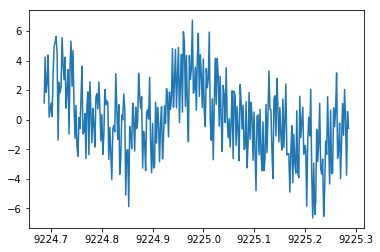

In [54]:
#average_epoch

#len(target_epochs)
min_epoch_reading_length = len(target_epochs[0].avg_channel)
time_stamps = target_epochs[0].eeg_time_stamps
for target_epoch in target_epochs:
    if len(target_epoch.avg_channel) < min_epoch_reading_length:
        min_epoch_reading_length = len(target_epoch.avg_channel)
        time_stamps = target_epoch.eeg_time_stamps



fig = plt.figure()
ax1 = fig.add_subplot(111)

average_epoch = []
for reading_index in range(min_epoch_reading_length):
    avg_reading = 0
    for epoch_index in range(len(target_epochs)):
        avg_reading = avg_reading + target_epochs[epoch_index].avg_channel[reading_index]
    avg_reading = avg_reading / len(target_epochs)
    average_epoch.append(avg_reading)


ax1.plot(time_stamps, average_epoch)

In [55]:
sessions = [0,1,2,3,4]
target_epochs = []
stim_epochs = []
epoch_length = .6


for session_ID in sessions: 
    
    query = 'select * from session_eeg where session_ID = {0}'.format(session_ID)

    eeg = CasJobs.executeQuery(sql=query, context='MyDB')

    query = 'select * from stim_timestamps where session_ID = {0}'.format(session_ID)

    stim = CasJobs.executeQuery(sql=query, context='MyDB')

    target_timestamps_query = '''with targets(target_stim_ID) as (select stim_ID from image_stims where stim_training_class = 'target')
    select timestamp from stim_timestamps, targets where stim_timestamps.stim_ID = targets.target_stim_ID and stim_timestamps.session_ID = {0}'''.format(session_ID)

    target_timestamps = CasJobs.executeQuery(sql=target_timestamps_query, context='MyDB')
    
    for target_time in target_timestamps['timestamp']:
        cur_epoch = EpochData(target_time)
        for index in range(len(eeg['timestamp'])):
            if target_time < eeg['timestamp'][index]:
                continue
            elif target_time < eeg['timestamp'][index] + epoch_length:
                eeg_values = []
                for col in eeg.columns[2:]:
                    eeg_values.append(eeg[col][index])
                cur_epoch.addEEGTimeValue(eeg['timestamp'][index], eeg_values)
            else:
                continue
        cur_epoch.zeroVoltages()
        cur_epoch.calculateAverageChannel()
        target_epochs.append(cur_epoch)    
        
        
    

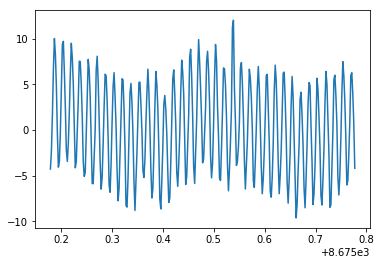

In [56]:
#grand average_epoch

#len(target_epochs)
min_epoch_reading_length = len(target_epochs[0].avg_channel)
time_stamps = target_epochs[0].eeg_time_stamps
for target_epoch in target_epochs:
    if len(target_epoch.avg_channel) < min_epoch_reading_length:
        min_epoch_reading_length = len(target_epoch.avg_channel)
        time_stamps = target_epoch.eeg_time_stamps



fig = plt.figure()
ax1 = fig.add_subplot(111)

average_epoch = []
for reading_index in range(min_epoch_reading_length):
    avg_reading = 0
    for epoch_index in range(len(target_epochs)):
        avg_reading = avg_reading + target_epochs[epoch_index].avg_channel[reading_index]
    avg_reading = avg_reading / len(target_epochs)
    average_epoch.append(avg_reading)


ax1.plot(time_stamps, average_epoch)

In [58]:
target_epoch_query = '''with stim_timestamp_class(session_ID, stim_timestamp, stim_class) as (select session_ID, timestamp, stim_training_class from stim_timestamps, image_stims where stim_timestamps.stim_ID = image_stims.stim_ID),
epoch_data as (select stim_timestamp_class.session_ID, stim_class, stim_timestamp, timestamp, F3, Fz, F4, T7, C3, Cz, C4, T8, Cp3, Cp4, P3, Pz, P4, PO7, PO8, Oz from stim_timestamp_class, session_eeg 
where stim_timestamp_class.session_ID = session_eeg.session_ID and session_eeg.timestamp >= stim_timestamp and session_eeg.timestamp <= stim_timestamp + .6)
select * from epoch_data where stim_class = 'target' and session_ID = 3 order by session_ID, stim_timestamp, timestamp'''